<a href="https://colab.research.google.com/github/giacomogreggio/computer-vision-project/blob/master/VGG_FCN8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing additional Libraries

In [ ]:
import math
import numpy as np
import keras


import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, MaxPool2D, ZeroPadding2D, Cropping2D, Softmax, Add, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.metrics import MeanIoU
import tensorflow_datasets as tfds


tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt

#Important Hyperparameters

In [2]:
IMAGE_SHAPE=(128,128,3)
N_CLASSES=3
L2_VALUE=5**-4

BATCH_SIZE = 128
BUFFER_SIZE = 1000
EPOCHS = 500
VAL_SUBSPLITS = 5

# Downloading the Dataset

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

The following code performs a simple augmentation of flipping an image. In addition,  image is normalized to [0,1]. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required splits of test and train and so let's continue to use the same split.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Let's take a look at an image example and it's correponding mask from the dataset.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

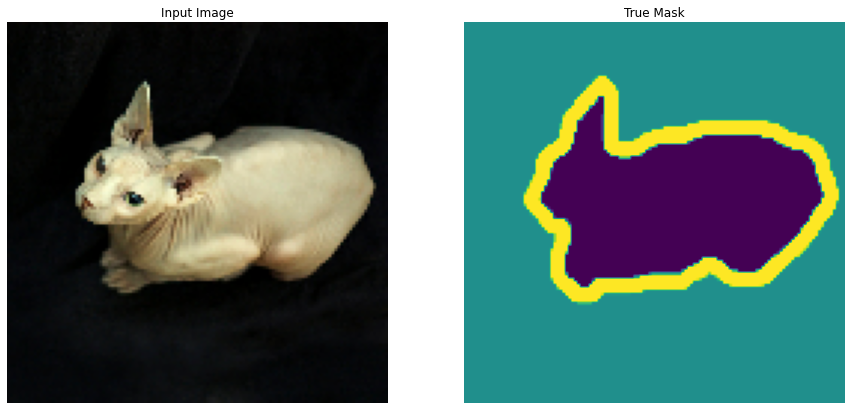

In [11]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# Defining the models

In [12]:
def calculate_output_shape(input_layer, last_layer):
  return np.array(Model(input_layer, last_layer).layers[-1].output_shape[1:])

def calculate_crop_value(output_shape, size_to_crop):
    pixel_difference=output_shape-size_to_crop

    half_height_left=int(pixel_difference[0]/2)
    half_height_right=math.ceil(pixel_difference[0]/2)
    half_width_left=int(pixel_difference[1]/2)
    half_width_right=math.ceil(pixel_difference[1]/2)

    return tuple([tuple([half_height_left,half_height_right]),tuple([half_width_left,half_width_right])])

## Base Vgg Architecture

In [ ]:
def create_base_vgg(trainable=True):
  #Defining Base VGG architecture
  input_layer = Input(shape=IMAGE_SHAPE, name="input")
  #VGG-block1
  b1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b1_1")(input_layer)
  b1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b1_2")(b1)
  b1 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b1")(b1)

  #VGG-block2
  b2 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b2_1")(b1)
  b2 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b2_2")(b2)
  b2 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b2")(b2)

  #VGG-block3
  b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b3_1")(b2)
  b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b3_2")(b3)
  b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b3_3")(b3)
  b3 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b3")(b3)

  #VGG-block4
  b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b4_1")(b3)
  b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b4_2")(b4)
  b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b4_3")(b4)
  b4 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b4")(b4)

  #VGG-block5
  b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b5_1")(b4)
  b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b5_2")(b5)
  b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(L2_VALUE), name="conv2d_b5_3")(b5)
  b5 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b5")(b5)

  vgg_model = Model(input_layer, b5)
  vgg16= VGG16(weights="imagenet", include_top=False)
  vgg16.save_weights("./weights.h5")
  vgg_model.load_weights("./weights.h5")
  vgg_model.trainable=trainable

  return vgg_model

## FCN-32

In [ ]:
def create_fcn32(vgg_trainable=True, include_top=True):
  vgg_model=create_base_vgg(trainable=vgg_trainable)
  b5=vgg_model.layers[-1].output
  input_layer=vgg_model.layers[0].output
  fcn_32_block = Conv2D(4096, kernel_size=(7,7), activation='relu', padding="same", kernel_regularizer=l2(L2_VALUE), name="conv2d_fcn32_1")(b5)
  fcn_32_block = Dropout(0.5, name="dropout_fcn32_1")(fcn_32_block)
  fcn_32_block = Conv2D(4096, kernel_size=(1,1), activation='relu', padding="same", kernel_regularizer=l2(L2_VALUE), name="conv2d_fcn32_2")(fcn_32_block)
  fcn_32_block = Dropout(0.5, name="dropout_fcn32_2")(fcn_32_block)
  fcn_32_block = Conv2D(N_CLASSES, kernel_size=(1,1), padding="same", kernel_regularizer=l2(L2_VALUE), name="conv2d_fcn32_3")(fcn_32_block)
  if include_top:
    fcn_32_transpose = Conv2DTranspose(N_CLASSES, kernel_size=(64,64), strides=(32,32), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fcn32")(fcn_32_block)
    crop_value=calculate_crop_value(calculate_output_shape(input_layer, fcn_32_transpose),IMAGE_SHAPE)
    fcn_32_crop = Cropping2D(crop_value, name="crop_fcn32")(fcn_32_transpose)
    fcn_32_softmax=Softmax(name="softmax_fcn32")(fcn_32_crop)
    return Model(input_layer, fcn_32_softmax)
  else:
    return Model(input_layer, fcn_32_block)

##FCN-16

In [ ]:
def create_fcn16(vgg_trainable=True, include_top=True):
  fcn_32=create_fcn32(vgg_trainable=vgg_trainable, include_top=False)
  input_layer=fcn_32.layers[0].output
  b4=fcn_32.get_layer("maxpool_b4").output
  fcn_32_block=fcn_32.layers[-1].output

  fcn_16_block_fcn32 = Conv2DTranspose(N_CLASSES, kernel_size=(4,4), padding="valid", strides=(2,2), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fcn16_1")(fcn_32_block)
  fcn_16_block = Conv2D(N_CLASSES, kernel_size=(1,1), activation="relu", kernel_regularizer=l2(L2_VALUE), padding="valid", name="conv2d_fcn16_1")(b4)

  crop_value=calculate_crop_value(calculate_output_shape(input_layer, fcn_16_block_fcn32),calculate_output_shape(input_layer, fcn_16_block))
  fcn_16_block_fcn32 = Cropping2D(crop_value, name="crop_fnc16_1")(fcn_16_block_fcn32)

  fcn_16_block = Add(name="add_fcn16")([fcn_16_block_fcn32,fcn_16_block])

  if include_top:
    fcn_16_deconv = Conv2DTranspose(N_CLASSES, kernel_size=(32,32), strides=(16,16), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fcn16_2")(fcn_16_block)
    crop_value=calculate_crop_value(calculate_output_shape(input_layer, fcn_16_deconv),IMAGE_SHAPE)
    fcn_16_crop = Cropping2D(crop_value, name="crop_fcn16_2")(fcn_16_deconv)
    fcn_16_softmax=Softmax(name="softmax_fcn16")(fcn_16_crop)
    return Model(input_layer, fcn_16_softmax)
  else:
    return Model(input_layer, fcn_16_block)

#FCN-8

In [16]:
def create_fcn8(vgg_trainable=True, include_top=True):
  fcn_16=create_fcn16(vgg_trainable=vgg_trainable, include_top=False)
  input_layer=fcn_16.layers[0].output
  b3=fcn_16.get_layer("maxpool_b3").output
  fcn_16_block=fcn_16.layers[-1].output

  fcn_8_block_fcn16 = Conv2DTranspose(N_CLASSES, kernel_size=(4,4), padding="valid", strides=(2,2), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fnc8_1")(fcn_16_block)
  fcn_8_block = Conv2D(N_CLASSES, kernel_size=(1,1), activation="relu", kernel_regularizer=l2(L2_VALUE), padding="valid", name="conv2d_fcn8_1")(b3)

  crop_value=calculate_crop_value(calculate_output_shape(input_layer, fcn_8_block_fcn16),calculate_output_shape(input_layer, fcn_8_block))
  fcn_8_block_fcn16 = Cropping2D(crop_value, name="crop_fnc8_1")(fcn_8_block_fcn16)
  
  fcn_8_block = Add(name="add_fcn8")([fcn_8_block_fcn16,fcn_8_block])

  if include_top:
    fcn_8_deconv = Conv2DTranspose(N_CLASSES, kernel_size=(16,16), strides=(8,8), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fnc8_2")(fcn_8_block)
    crop_value=calculate_crop_value(calculate_output_shape(input_layer, fcn_8_deconv),IMAGE_SHAPE)
    fcn_8_crop = Cropping2D(crop_value, name="crop_fcn8_2")(fcn_8_deconv)
    fcn_8_softmax=Softmax(name="softmax_fcn8")(fcn_8_crop)
    return Model(input_layer, fcn_8_softmax)
  else:
    return Model(input_layer, fcn_8_block)

#Training the model

##Defining Useful Callbacks

In [17]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [18]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [20]:
class print_lr(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print("Current Learning rate : {}".format(self.model.optimizer.lr.numpy()))

In [21]:
class AdaptedMeanIoU(tf.keras.metrics.Metric):
  def __init__(self, name='mean_iou', N_CLASSES=3,**kwargs):
    super(AdaptedMeanIoU, self).__init__(name=name, **kwargs)
    self.mean_iou=MeanIoU(N_CLASSES)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred_converted=tf.argmax(y_pred,axis=-1)
    self.mean_iou.update_state(y_true,y_pred_converted)
  def result(self):
    return self.mean_iou.result()
  def reset_states(self):
    self.mean_iou.reset_states()

In [22]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, min_lr=1**-10)

In [23]:
callbacks=[
    keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
    DisplayCallback(),
    reduce_lr, 
    print_lr()
]

## Training FCN8

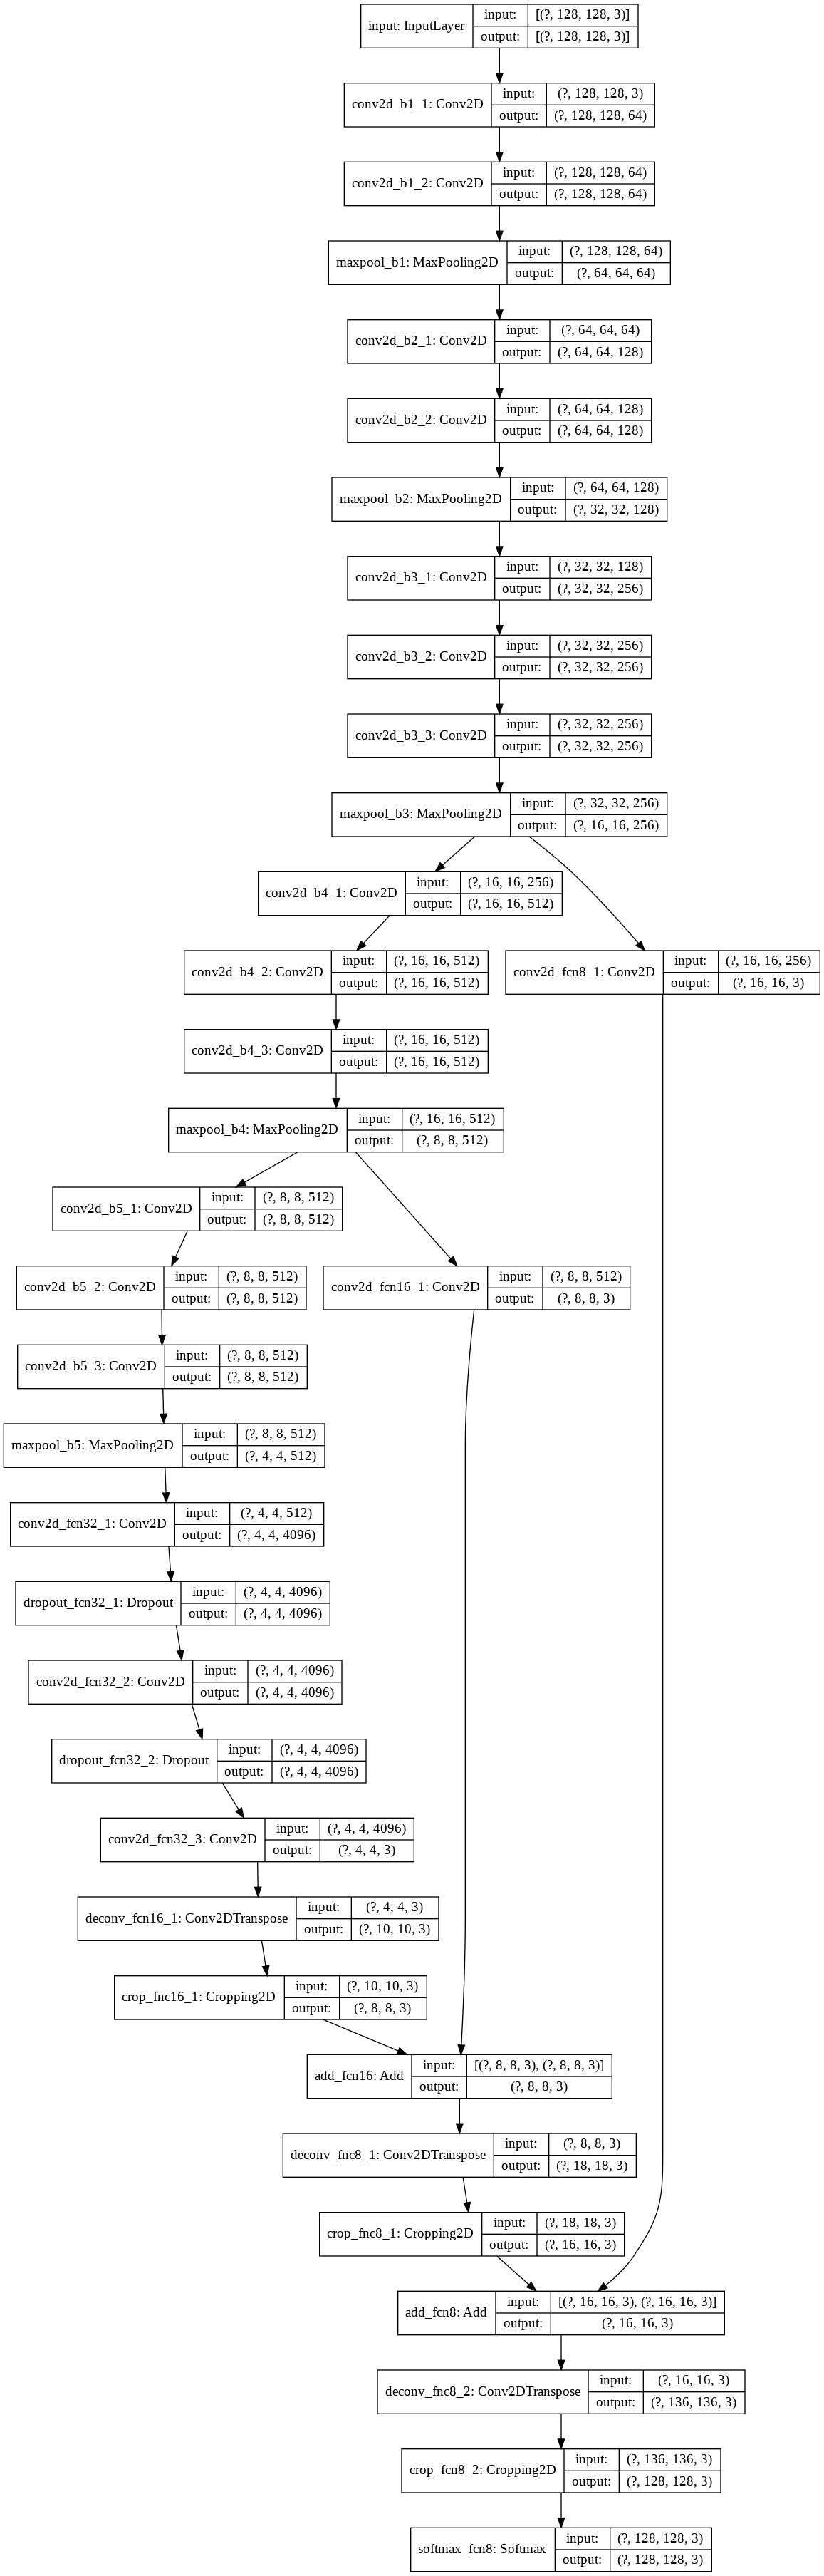

In [24]:
model=create_fcn8()
model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, clipnorm=1), loss=SparseCategoricalCrossentropy(), metrics=[AdaptedMeanIoU(N_CLASSES=3)])
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(),reduce_lr, print_lr()])

In [ ]:
model = keras.models.load_model("my_mnist_model.h5")

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

In [ ]:
show_predictions(test_dataset, 10)